# How to use CGA2M+ package!

In [1]:
import sys
sys.path.append("../src/")

#import CGA2M+
from CGA2M_plus.cga2m import Constraint_GA2M
from CGA2M_plus.visualize import *

#ML Algorithm
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Other
import copy
import itertools
import warnings

#AutoReload
%load_ext autoreload
%autoreload 2

np.random.seed(2021)

# Make sample dataset(Example data set)
$$\displaystyle y = (1+0.2\epsilon_1)x_0 + \exp(-\frac{1}{3}x_1^2)+ \sin(2\pi x_2) - \frac{1}{3}x_2x_4  +\frac{1}{3}\exp(\frac{1}{8}(x_3 + x_4 - x_5)^2) + \epsilon_2$$

$$\epsilon_1,\epsilon_2 \sim N(0,1)$$

In [2]:
def sample_data(x):
    y =  (1+0.2*np.random.normal(size=1).item())*x[0] +  np.exp(- 1/3 * x[1]**2) +  np.sin(2* np.pi * x[2]) - 1/3 * x[2]*x[4] + 1/3 * np.exp(1/8*(x[3] + x[4] - x[5])**2) 
    y = y + np.random.normal(size=1).item()#noise
    return y

In [3]:
#n_samples： sample size
#n_features: the number of features

num_features = 7 #meaningful features x_0 ~x_5, meaningless feature x_6
n_samples = 30000
data = 4 * np.random.random_sample((n_samples,num_features)) - 2
target = list()
for i in range(data.shape[0]):
    y = sample_data(data[i])
    target.append(y)

target = np.array(target)
print(data.shape)
print(target.shape)


#Split the data into 3 sets(train, validation and test)
X_train, X_test, y_train, y_test = train_test_split(data,target,train_size=0.7,random_state=2021)
X_eval, X_test, y_eval, y_test = train_test_split(X_test,y_test,train_size=0.5,random_state=2021)#random_stateは変更しない

#Check the sample size of 3 sets(train, validation and test)
print('X_train',X_train.shape)
print('y_train',y_train.shape)

print('X_eval',X_eval.shape)
print('y_eval',y_eval.shape)

print('X_test',X_test.shape)
print('y_test',y_test.shape)

(30000, 7)
(30000,)
X_train (21000, 7)
y_train (21000,)
X_eval (4500, 7)
y_eval (4500,)
X_test (4500, 7)
y_test (4500,)


In [4]:
print(np.mean(y_train))
print(np.min(y_train))
print(np.max(y_train))

1.443274768558458
-5.007631785246939
22.337004822595667


# Training CGA2M+ and visualization 

In [5]:
# parameters of LightGBM in CGA2M+
lgbm_params = {'objective':'regression',
               'metric':'rmse',
               'verbose': -1}

#Input the data into the model.
#all_interaction_features is List which contains the interactions to be taken into account. Note that the interactions are set to (i<j) for uniqueness.
cga2m_no1 = Constraint_GA2M(X_train,
                            y_train,
                            X_eval,
                            y_eval,
                            lgbm_params,
                            monotone_constraints=None,
                            all_interaction_features=list(itertools.combinations(range(X_test.shape[1]), 2)))

In [6]:
# Train (about 5min)

# max_outer_iteration is the number of iterations in GA2M Framework(==Maximum number of interactions)
## the interactions refer to [(1,2),(1,3),...]
max_outer_iteration = len(list(itertools.combinations(range(X_test.shape[1]), 2)))
print("max_outer_iteration=",max_outer_iteration)

# backfitting_iteration ： The number of iterations of backfitting
# threshold ： If the importance of the variable pair is below this threshold, we finish training.
cga2m_no1.train(max_outer_iteration=max_outer_iteration,backfitting_iteration=20,threshold=0.05)

#Delete ineffective shape functions(e.g. f_i,f_{i,j}) and train again.
## threshold ： If the importance of the variable is below threshold, we consider that it is ineffective.
print('START prune_and_retrain')
cga2m_no1.prune_and_retrain(threshold=0.05,backfitting_iteration=30)

# Training higher-order terms (if you do not need this, comment out!)
cga2m_no1.higher_order_train()

max_outer_iteration= 21
START 1ST ITERATION
START 2ST ITERATION
START 3ST ITERATION
START 4ST ITERATION
START 5ST ITERATION
START 6ST ITERATION
START 7ST ITERATION
START 8ST ITERATION
START 9ST ITERATION
End of training
START prune_and_retrain


In [7]:
# Pridict
## higher_mode ： True if you want to use the result of the higher order term (False by default).
preds_higher = cga2m_no1.predict(X_test,higher_mode=True)
preds = cga2m_no1.predict(X_test)
# Calculate RMSE for test data
mse_higher = mean_squared_error(y_test, preds_higher)
mse = mean_squared_error(y_test, preds)

rmse_higher = np.sqrt(mse_higher)
rmse = np.sqrt(mse)

print('RMSE(test) with the higher-order term',rmse_higher)
print('RMSE(test) without the higher-order term',rmse)


preds_higher = cga2m_no1.predict(X_train,higher_mode=True)
preds = cga2m_no1.predict(X_train)
# Calculate RMSE for training data
mse_higher = mean_squared_error(y_train, preds_higher)
mse = mean_squared_error(y_train, preds)

rmse_higher = np.sqrt(mse_higher)
rmse = np.sqrt(mse)

print('RMSE(train) with the higher-order term',rmse_higher)
print('RMSE(train) without the higher-order term',rmse)

RMSE(test) with the higher-order term 1.192632909738785
RMSE(test) without the higher-order term 1.227824471758763
RMSE(train) with the higher-order term 0.8430031138238707
RMSE(train) without the higher-order term 0.9251810912846228


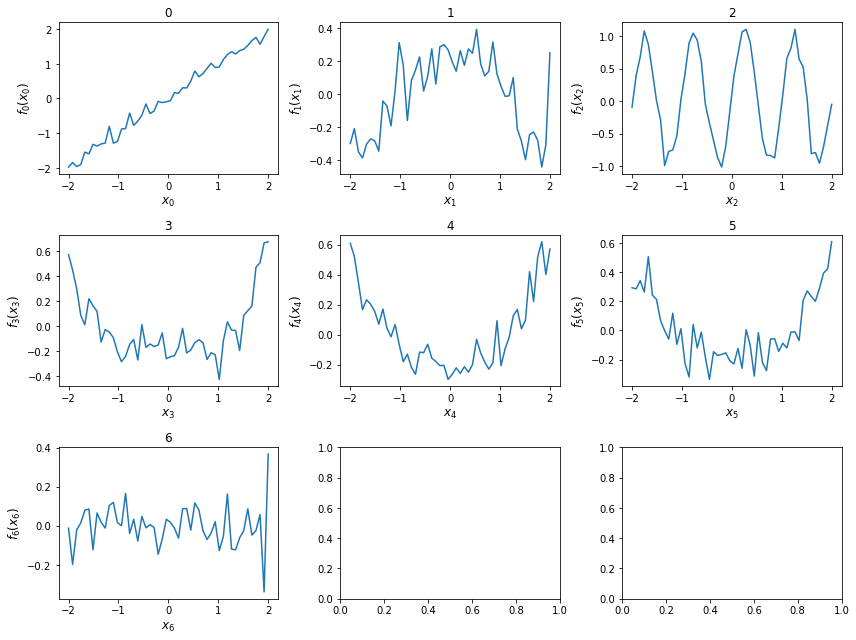

In [8]:
# Visualize the effect of features on the target variables
plot_main(cga2m_no1,X_train)

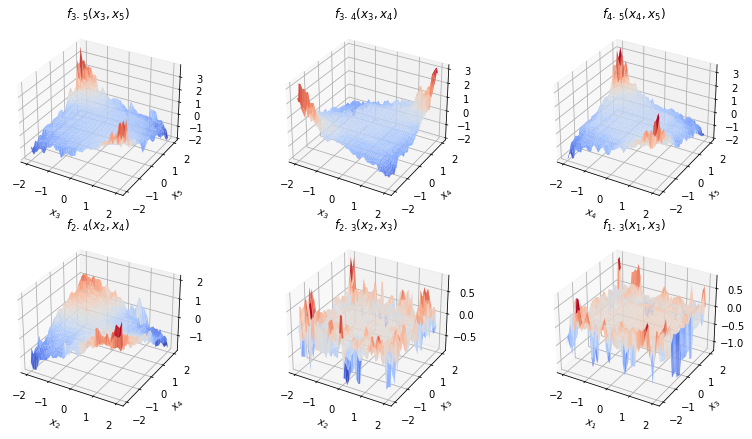

In [9]:
#Visualize (3d) the effect of pairs of features on the target variables
plot_interaction(cga2m_no1,X_train,mode = "3d")

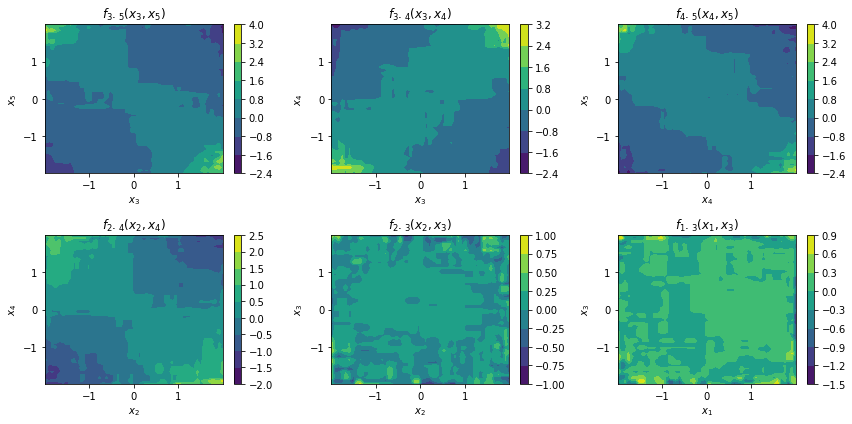

In [10]:
#Visualize (2d) the effect of pairs of features on the target variables
plot_interaction(cga2m_no1,X_train,mode = "2d")

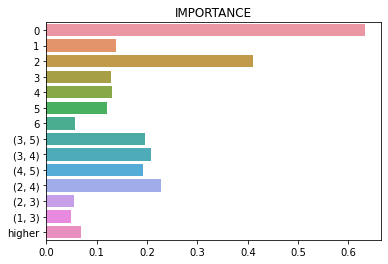

In [11]:
# Feature Importance
## after_prune： If True, display the feature importance after pruning.
## higher_mode: If True, display the feature importance which contain the effect of the higher-order term.
show_importance(cga2m_no1,after_prune=True,higher_mode=True)

In [12]:
# Selected features
print("Selected features")
print(cga2m_no1.use_main_features,"\n")

# Pairs of selected features (interaction)
print("Pairs of selected features (interaction)")
print(cga2m_no1.use_interaction_features,"\n")

# Feature Importance after pruning
print("Feature Importance after pruning")
print(cga2m_no1.after_feature_importance_,"\n")

# Feature Importance before pruning
print("Feature Importance before pruning")
print(cga2m_no1.before_feature_importance_)

Selected features
[0, 1, 2, 3, 4, 5, 6] 

Pairs of selected features (interaction)
[(3, 5), (3, 4), (4, 5), (2, 4), (2, 3), (1, 3)] 

Feature Importance after pruning
{0: 0.633392043866198, 1: 0.1375802338586143, 2: 0.40978674472942883, 3: 0.12813562977042145, 4: 0.1307073499774606, 5: 0.12063237512840794, 6: 0.056437720552546415, (3, 5): 0.19483815505085672, (3, 4): 0.20685491267673345, (4, 5): 0.19268456099874567, (2, 4): 0.22713819687295386, (2, 3): 0.054471658396229986, (1, 3): 0.04786235992822891, 'higher': 0.06875713697261573} 

Feature Importance before pruning
{0: 0.6295763014463029, 1: 0.1374524920845846, 2: 0.410635617796357, 3: 0.13027530481618385, 4: 0.13592643124116868, 5: 0.12444194050845682, 6: 0.05621094219527024, (3, 5): 0.19441289105214876, (3, 4): 0.2093836690781018, (4, 5): 0.1916523847390596, (2, 4): 0.22907313106379773, (2, 3): 0.051719230408024223, (1, 3): 0.05301057504551453, (0, 3): 0.04755690895513956, (0, 4): 0.048329654535105245}


## Apply monotonic constraints to some shape functions of the model
You have a lot of knowledge about the data. (For example, in real estate prices, you know that the larger the room, the higher the rent.)
In this case, you may impose monotonic constrains on some features.
In this example, we apply a monotonic constraint to x_0.  

### How to set monotonic constraints
The monotonic constraints are set as `monotone_constraints=[1,0,-1]`.
Monotonically increasing if `1`, monotonically decreasing if `-1`, unconstrained(No setting) if `0`.
Assign 1, -1, or 0 to all indices for each feature in training data. 
 
Ex)
Four features. The second feature is monotonically increasing. The fourth feature is monotonically decreasing.  
`monotone_constraints=[0,1,0,-1]`

In [13]:
# Training model with constraint

cga2m_no2 = Constraint_GA2M(X_train,
                            y_train,
                            X_eval,
                            y_eval,
                            lgbm_params,
                            monotone_constraints=[1,0,0,0,0,0,0],# monotonic constraints
                            all_interaction_features=list(itertools.combinations(range(X_test.shape[1]), 2)))

print(cga2m_no2.use_main_features)
print(cga2m_no2.remaining_interaction_features)

cga2m_no2.train(max_outer_iteration=max_outer_iteration,backfitting_iteration=20,threshold=0.05)

print('START prune_and_retrain')
cga2m_no2.prune_and_retrain(threshold=0.05,backfitting_iteration=30)

cga2m_no2.higher_order_train()

[0, 1, 2, 3, 4, 5, 6]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]
START 1ST ITERATION
START 2ST ITERATION
START 3ST ITERATION
START 4ST ITERATION
START 5ST ITERATION
START 6ST ITERATION
START 7ST ITERATION
End of training
START prune_and_retrain


In [14]:
#Pridict
## higher_mode ： True if you want to use the result of the higher order term (False by default).

preds_higher = cga2m_no2.predict(X_test,higher_mode=True)
preds = cga2m_no2.predict(X_test)
# Calculate RMSE for test data
mse_higher = mean_squared_error(y_test, preds_higher)
mse = mean_squared_error(y_test, preds)

rmse_higher = np.sqrt(mse_higher)
rmse = np.sqrt(mse)

print('RMSE(test) with the higher-order term',rmse_higher)
print('RMSE(test) without the higher-order term',rmse)


preds_higher = cga2m_no2.predict(X_train,higher_mode=True)
preds = cga2m_no2.predict(X_train)
# Calculate RMSE for training data
mse_higher = mean_squared_error(y_train, preds_higher)
mse = mean_squared_error(y_train, preds)

rmse_higher = np.sqrt(mse_higher)
rmse = np.sqrt(mse)

print('RMSE(train) with the higher-order term',rmse_higher)
print('RMSE(train) without the higher-order term',rmse)

RMSE(test) with the higher-order term 1.1924052434048797
RMSE(test) without the higher-order term 1.2022442296915699
RMSE(train) with the higher-order term 0.9106556521970014
RMSE(train) without the higher-order term 0.9857262714318759


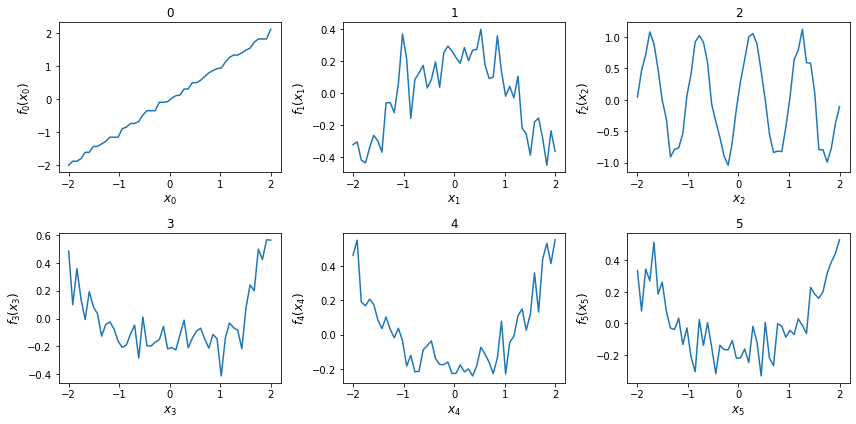

In [15]:
# Visualize the effect of features on the target variables
plot_main(cga2m_no2,X_train)

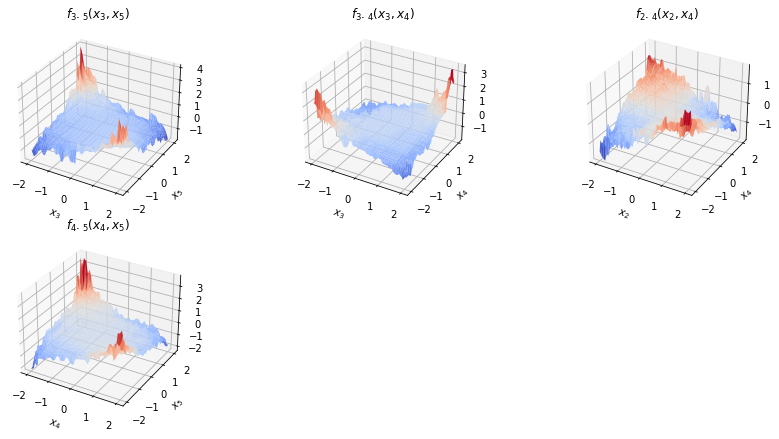

In [16]:
#Visualize the effect of pairs of features on the target variables
plot_interaction(cga2m_no2,X_train)

# Delete some features or pairs of features
We will show you how to remove a feature (or a pair of features) from the model you have just trained, and how to retrain the model.
There are two ways to do this.

1. From the features and pairs of features used in the previously trained model, delete the features and pairs which are meaningless. Then, you train the model with the features and pairs of features determined.
2. Decide which features and feature pairs are not used, and train the model from the beginning.


### 1. From the features and pairs of features used in the previously trained model, delete the features and pairs which are meaningless. Then, you train the model with the features and pairs of features determined.
You have examined your data and your model(```cga2m_no1```) and determined that (x_1,x_3) is not needed among the features and feature pairs.  
In this example, you remove (x_1,x_3) from your model(```cga2m_no1```) and retrain the model.

In [17]:
# Remove (x_1,x_3) from the model(cga2m_no1).
cga2m_no1.use_interaction_features.remove((1,3))

# if you remove x_5 from the model, type "cga2m.use_main_features.remove(5)".

print("use_main_features",cga2m_no1.use_main_features)
print("use_interaction_features",cga2m_no1.use_interaction_features)

use_main_features [0, 1, 2, 3, 4, 5, 6]
use_interaction_features [(3, 5), (3, 4), (4, 5), (2, 4), (2, 3)]


In [18]:
# Training again.
cga2m_no1.retrain(backfitting_iteration=30)
# Train higher-order term
cga2m_no1.higher_order_train()

### 2. Decide which features and feature pairs are not used, and train the model from the beginning.

In [19]:
use_interaction_features = list(itertools.combinations(range(X_test.shape[1]), 2))
use_interaction_features.remove((1,3))# remove (x_1,x_3)

cga2m_no1 = Constraint_GA2M(X_train,
                            y_train,
                            X_eval,
                            y_eval,
                            lgbm_params,
                            monotone_constraints=None,
                            all_interaction_features=use_interaction_features)

cga2m_no1.use_main_features.remove(5)# remove x_5

In [20]:
max_outer_iteration = len(use_interaction_features)
print("max_outer_iteration=",max_outer_iteration)
cga2m_no1.train(max_outer_iteration=max_outer_iteration,backfitting_iteration=20,threshold=0.05)
cga2m_no1.prune_and_retrain(threshold=0.05,backfitting_iteration=30)
cga2m_no1.higher_order_train()

max_outer_iteration= 20
START 1ST ITERATION
START 2ST ITERATION
START 3ST ITERATION
START 4ST ITERATION
START 5ST ITERATION
START 6ST ITERATION
START 7ST ITERATION
START 8ST ITERATION
START 9ST ITERATION
START 10ST ITERATION
End of training
